<a href="https://colab.research.google.com/github/NoelleI/AI-Experiments-Pigmentation/blob/master/Pigmentation_EXP2_cleaned_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma with CNN

This analysis trains a neural network to perform segmentation on melanoma data and then applies the algorithm to segment a pigmentation lesion

This line clones the github repository so that data may be accessed and the file can be saved there

In [2]:
!git clone https://github.com/NoelleI/Pigmentation.git

fatal: destination path 'Pigmentation' already exists and is not an empty directory.


This mounts Google Drive to access the ~10G melanoma photo data sets

1.   List item
2.   List item



In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


Import Packages with required versions

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline


In [0]:
import skimage


In [0]:
import numpy as np


In [7]:
import scipy
scipy.__version__

'1.0.0'

In [8]:
!pip install pillow

In [0]:
if not (scipy.__version__ == '1.0.0'):
  !pip uninstall scipy==1.3.0
  !pip install scipy==1.0.0

In [0]:

from skimage import data
from skimage.color import rgb2hsv, rgb2lab

Get Pigmentation Photos

In [11]:
from scipy import ndimage, misc
import re
import os
from datetime import datetime

pigs = []
filenames_dict = {}
str = "./Pigmentation/Pigmentation_photos/Experiment 2/Spot 1"    #photo directory on cloned repository for experimental pigmentation data


for root, dirnames, filenames in os.walk(str): 
    #print(filenames)
    for filename in filenames:
           # print(filename, "\n")
      #if re.search('d*[^{r|f}].jpg', filename):
            n =  re.match("(.*)(2019)(\d*_\d*)_(.*)", filename)
            key = n.group(3)

            key = datetime.strptime(key, '%m%d_%H%M%S')
           # print(key, " ")
           # print(filename, "\n")
            #print(os.path.join(root, filename), "\n")
            filenames_dict.update({key: os.path.join(root, filename)})
            #print(filenames_dict, "\n\n")
#print(filenames_dict.keys(),"\n")
for key in sorted(filenames_dict.keys()):
  #print(key,filenames_dict[key], "\n")
  image = ndimage.imread(filenames_dict[key], mode="RGB")
  image = skimage.transform.resize(image, (192,256,3))  
  
  pigs+= [image]
  
  
pigs = np.asarray(pigs)
            



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Retrieve unordered filenames for Melanoma training set from directory using os

In [0]:
from scipy import ndimage, misc
import re
import os
#there are 2594 photos
filenames_dict = {}
for root, dirnames, filenames in os.walk("/content/gdrive/My Drive/Batches/ISIC2018_Task1-2_Training_Input_batches"): #/content/gdrive/My Drive/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input"):
    for filename in filenames:
      if re.search('d*[^{r|f}].jpg', filename):
            n = re.match("ISIC_(\d*).", filename)
            filenames_dict.update({n.group(1): os.path.join(root, filename)})
           
           
for root, dirnames, filenames in os.walk("/content/gdrive/My Drive/Batches/ISIC2018_Task1-2_Testing_Input_batches"): #/content/gdrive/My Drive/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input"):
    for filename in filenames:
      if re.search('d*[^{r|f}].jpg', filename):
            n = re.match("ISIC_(\d*).", filename)
            filenames_dict.update({n.group(1): os.path.join(root, filename)})


In [0]:
#"/content/gdrive/My Drive/Batches/ISIC2018_Task1_Training_GroundTruth_batches"

from scipy import ndimage, misc
import re
import os
#there are 2594 photos
labelnames_dict = {}
for root, dirnames, filenames in os.walk("/content/gdrive/My Drive/Batches/ISIC2018_Task1_Training_GroundTruth_batches"): #/content/gdrive/My Drive/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input"):
    for filename in filenames:
      if re.search('d*[^{r|f}]_segmentation.png', filename):
           
            n = re.match("ISIC_(\d*)_\w+", filename)
            labelnames_dict.update({n.group(1): os.path.join(root, filename)})
           
for root, dirnames, filenames in os.walk("/content/gdrive/My Drive/Batches/ISIC2018_Task1_Testing_GroundTruth_batches"): #/content/gdrive/My Drive/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input"):
    for filename in filenames:
      if re.search('d*[^{r|f}]_segmentation.png', filename):
            n = re.match("ISIC_(\d*)_\w+", filename)
            labelnames_dict.update({n.group(1): os.path.join(root, filename)})
            

Order the photos using dictionary sorting

In [14]:
images = []
segs = []
for key in sorted(labelnames_dict.keys()):
  image = ndimage.imread(filenames_dict[key], mode="RGB")
  seg = ndimage.imread(labelnames_dict[key], mode="L")
  images += [image]
  segs += [seg]
  
images = np.array(images)
segs = np.array(segs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """


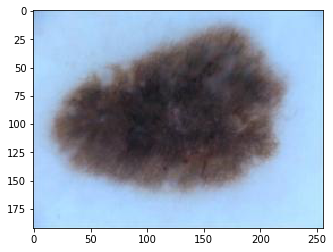

In [15]:
image = images[0,:,:,:]
plt.imshow(image)
plt.show()

### Helper Functions

Function to help intialize random weights for fully connected or convolutional layers and deconvolutional layers

In [0]:
from sklearn.model_selection import train_test_split
trainim, testim, trainlab, testlab = train_test_split(images, segs, test_size = 0.05) #this is randomized each time the program is started and run from scratch

In [17]:
trainim.shape

(2464, 192, 256, 3)

In [18]:
np.max(testlab)

255

In [19]:
testlab.shape

(130, 192, 256)

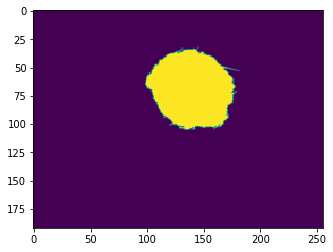

In [20]:
image = trainlab[0,:,:]
plt.imshow(image)
plt.show()

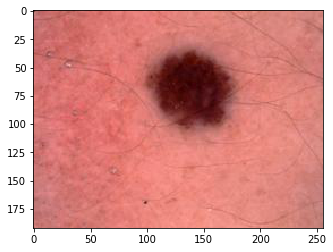

In [21]:
image = trainim[0,:,:,:]
plt.imshow(image)
plt.show()

In [0]:
def data_augmentations(features,lables,flag):
  if flag:
    #print("treat the first input image")
    #hsv_img = rgb2hsv(features[0])  #add 3 hsv channels       
    #plt.imshow(features[0])
    #plt.show()
    #plt.imshow(hsv_img)
    #plt.show()
    #print(hsv_img.dtype)
    #print(features[0].dtype)
    #print(hsv_img)
    #print(features[0])
    #l = rgb2lab(features[0])[:,:,0].reshape(192,256,1) #add the l channel from the lab space
    #image = np.concatenate((features[0]/255,hsv_img,l), axis =2)  #concatenate into one big image
    x2 = features[0].reshape([1,192,256,3]) #image.reshape([1,192,256,7])  #need to add "1" to first dimension for future concatenation
    image = features[0]
    #print("#flip the first image:")
    flip_ud_x2 = np.flipud(image).reshape([1,192,256,3])
    #plt.imshow(flip_ud_x2[0,:,:,:3])
   
    #plt.show()
    x2 = np.vstack((x2, flip_ud_x2)) 
    
    #print("#rotate the first image by a random angle")
    ra = np.random.random()*360
    rotate_x2 = ndimage.rotate(image, ra)
    #print(image)
    #print(rotate_x2)
    #plt.imshow(rotate_x2[:,:,:3])
    #plt.show()
    #print("test1")
    rotate_x2 = skimage.transform.resize(rotate_x2, (1,192,256,3))
    #plt.imshow(rotate_x2[0,:,:,:3])
    #print("test2")
    x2 = np.vstack((x2, rotate_x2 )) 
    
    #print("#treat the first label:")
    label = lables[0]
    #plt.imshow(label)
    #plt.show()
    y2 = label.reshape([1,192,256,1])
    #print("#flip the first label to match the first input image:")
    flip_ud_y2 = np.flipud(label).reshape([1,192,256,1])
    y2 = np.vstack((y2, flip_ud_y2)) 
    #plt.imshow(flip_ud_y2[0:,:,:,:])
    #plt.show()
    #print("#rotate the label by the same angle as the image")
    rotate_y2 = ndimage.rotate(label, ra)
    rotate_y2 = skimage.transform.resize(rotate_y2, (1,192,256,1))
    y2 = np.vstack((y2, rotate_y2)) 
    #plt.imshow(rotate_y2) 
    #plt.show()
  
    i = 1
    
    #print('#treat the subsequent images and labels')
    for image in features[1:]:
      #print(i)
      #plt.imshow(image)
      #plt.show()
      #hsv_img = rgb2hsv(image)  #add 3 hsv channels       
      #plt.imshow(hsv_img)
      #plt.show()
      #l = rgb2lab(image)[:,:,0].reshape(192,256,1) #add the l channel from the lab space
      #image = np.concatenate((image,hsv_img,l), axis =2)  #concatenate into one big image
      image2 = image.reshape([1,192,256,3])  #need to add "1" to first dimension for future concatenation
      
      x2 = np.vstack((x2, image2))
      #print('#flip the image:')
      flip_ud_x2 = np.flipud(image).reshape([1,192,256,3])
      x2 = np.vstack((x2, flip_ud_x2))
      #plt.imshow(flip_ud_x2[1,:,:,:3])
      #plt.show()
     
      #print('#rotate the image by a random angle')
      ra = np.random.random()*360
      rotate_x2 = ndimage.rotate(image, ra)
      rotate_x2 = skimage.transform.resize(rotate_x2, (1,192,256,3))
      x2 = np.vstack((x2, rotate_x2))
      #plt.imshow(rotate_x2[0,:,:,:3])
      #plt.show()
      
     
      #print('#treat the corresponding label:')
      label = lables[i]
      label2 = lables[i].reshape([1,192,256,1])
      #plt.imshow(label)
      #plt.show()
     
      y2 = np.vstack((y2,label2))
      #print('#flip the corresponding label to match the input image:')
      flip_ud_y2 = np.flipud(label).reshape([1,192,256,1])
      y2 = np.vstack((y2,flip_ud_y2))
      #plt.imshow(flip_ud_y2[0,:,:,:])
      #plt.show()
      
      
      #print('#rotate the label by the same angle as the image')
      rotate_y2 = ndimage.rotate(label, ra)
      rotate_y2 = skimage.transform.resize(rotate_y2, (1,192,256,1))
      y2 = np.vstack((y2,rotate_y2))
      #plt.imshow(rotate_y2) 
      #plt.show()
      
      #print('#scale images to 0-1 interval')
    x2 = x2/255
    y2 = y2/255
  else:
     x2 = features/255
     y2 = lables/255
  return x2, y2

In [0]:
class MelHelper():
    
    def __init__(self):
        self.i = 0
        
        ####Can probably eliminate this part ####
        
        # Grabs a list of all the data batches for training
        #self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        #self.test_batch = [test_batch]
        
        ###eliminate####
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
       
        self.training_images = trainim   #normalize only ->replace with images with training set later
                                #self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
       
        self.training_labels = np.around(trainlab) #one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        self.test_images, labls = data_augmentations(testim, testlab,0)
        
        self.test_labels = labls.reshape((labls.shape[0],192,256))
       
        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100 - this is now a mistake
        xtra = (self.i + batch_size) % len(self.training_images)
        if xtra<batch_size and xtra != 0:
            x = np.vstack((self.training_images[self.i:self.i+batch_size], self.training_images[0:xtra])) #.reshape(100,32,32,3) 
            y = np.vstack((self.training_labels[self.i:self.i+batch_size], self.training_labels[0:xtra]))
        else:
            x = self.training_images[self.i:self.i+batch_size] #.reshape(100,32,32,3) 
            y = self.training_labels[self.i:self.i+batch_size]
        #print(x.shape)
        x,y = data_augmentations(x,y,0)
        y = y.reshape((y.shape[0],192,256))
        self.i = xtra 
        return x, y

In [0]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [0]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.


In [0]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [0]:
def deconv2d(x, shape):
    return tf.layers.conv2d_transpose(x, shape[3], shape[0:2], padding = 'SAME')

In [0]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [0]:
def convolutional_layer(input_x, shape):
    if input_x.shape[0]==1:
      training = False
    else: training = True
    W = init_weights(shape)
    b = init_bias([shape[3]])
    c = conv2d(input_x, W) + b   ###put batch normalization here because it should include the weights
    bnc = tf.layers.batch_normalization(c, training = training)
    return tf.nn.relu(bnc)

This is a normal fully connected layer

In [0]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

This is a Deconvolutional Layer

In [0]:
def deconvolutional_layer(input_x, shape):
    #W = init_weights(shape)
    if input_x.shape[0]==1:
      training = False
    else: training = True
    b = init_bias([shape[3]])  #draw this out to see if it makes sense
    d = deconv2d(input_x, shape) +b
    bnd = tf.layers.batch_normalization(d, training = training)
    return tf.nn.relu(bnd)

Finally, the output layer

In [0]:
def output_layer(input_x, shape):
    #W = init_weights(shape)
    if input_x.shape[0]==1:
      training = False
    else: training = True
    b = init_bias([shape[3]])  
    d = deconv2d(input_x, shape) +b
    
    return tf.nn.sigmoid(d)

In [33]:
images.shape

(2594, 192, 256, 3)

### Placeholders

In [0]:
x = tf.placeholder(tf.float32,shape=[None,192,256,images.shape[3]])  #trace the shaping of these through the code...


In [0]:

y_true = tf.placeholder(tf.float32,shape=[None,192,256])  #this now has every pixel in the ground truth segmentation

### Layers

In [0]:
x_image = tf.reshape(x,[-1,192,256,images.shape[3]])  #-1 infers the shape of the first dimension (here, the batch size)

In [37]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can change the 32 output, that essentially represents the amount of filters used
# You need to pass in 32 to the next input though, the 1 comes from the original input of 
# a single image.
convo_1 = convolutional_layer(x_image,shape=[3,3,images.shape[3],16])
convo_12 = convolutional_layer(convo_1,shape=[3,3,16,32])
convo_1_pooling = max_pool_2by2(convo_12)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.


In [38]:
print(convo_1_pooling.shape)

(?, 96, 128, 32)


In [0]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,32,64])
convo_22 = convolutional_layer(convo_2,shape=[3,3,64,64])
convo_2_pooling = max_pool_2by2(convo_22)

In [40]:
print(convo_2_pooling.shape)

(?, 48, 64, 64)


In [0]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
## You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_3 = convolutional_layer(convo_2_pooling,shape=[3,3,64,128])
convo_32 = convolutional_layer(convo_3,shape=[3,3,128,128])
convo_3_pooling = max_pool_2by2(convo_32)

In [42]:
print(convo_3_pooling.shape)

(?, 24, 32, 128)


In [43]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
hold_prob = tf.placeholder(tf.float32)

convo_3_pooling_d = tf.nn.dropout(convo_3_pooling,keep_prob=hold_prob)


convo_4 = convolutional_layer(convo_3_pooling_d,shape=[3,3,128,256])
convo_42 = convolutional_layer(convo_4,shape=[3,3,256,256])
convo_4_pooling = max_pool_2by2(convo_42)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
print(convo_4_pooling.shape)

(?, 12, 16, 256)


In [0]:
convo_5 = convolutional_layer(convo_4_pooling,shape=[3,3,256,512])
#convo_5_pooling = max_pool_2by2(convo_5)

In [46]:
print(convo_5.shape)

(?, 12, 16, 512)


In [0]:
#convo_6 = convolutional_layer(convo_5,shape=[3,3,128,256])
#convo_6_pooling = max_pool_2by2(convo_6)

In [0]:
#print(convo_6.shape)

Now add deconvolutional layers

In [49]:
#import keras
deconv_1 = deconvolutional_layer(convo_5, shape = [3,3,512,256])
H = deconv_1.shape[1]
W = deconv_1.shape[2]
ups_1 = tf.image.resize_nearest_neighbor(deconv_1, size = [2*H,2*W])
print(ups_1.shape)

Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
(?, 24, 32, 256)


In [50]:
deconv_2 = deconvolutional_layer(ups_1, shape = [3,3,256,256])
deconv_22 = deconvolutional_layer(deconv_2, shape = [3,3,256,128])
H = deconv_22.shape[1]
W = deconv_22.shape[2]
ups_2 = tf.image.resize_nearest_neighbor(deconv_22, size = [2*H,2*W])
print(ups_2.shape)

(?, 48, 64, 128)


In [51]:
deconv_3 = deconvolutional_layer(ups_2, shape = [4,4,128,128])
deconv_32 = deconvolutional_layer(deconv_3, shape = [3,3,128,128])
H = deconv_32.shape[1]
W = deconv_32.shape[2]
ups_3 = tf.image.resize_nearest_neighbor(deconv_32, size = [2*H,2*W])
print(ups_3.shape)

(?, 96, 128, 128)


In [52]:
deconv_4 = deconvolutional_layer(ups_3, shape = [3,3,128,64])
deconv_42 = deconvolutional_layer(deconv_4, shape = [3,3,64,32])
H = deconv_42.shape[1]
W = deconv_42.shape[2]
ups_4 = tf.image.resize_nearest_neighbor(deconv_42, size = [2*H,2*W])
print(ups_4.shape)

(?, 192, 256, 32)


In [53]:
hold_prob2 = tf.placeholder(tf.float32)

ups_4_d = tf.nn.dropout(ups_4,keep_prob=hold_prob2)

deconv_5 = deconvolutional_layer(ups_4_d, shape = [3,3,32,16])
print(deconv_5.shape)
output = output_layer(deconv_5, shape = [3,3,16,1])
#print(deconv_52.shape)
#output = tf.image.resize_nearest_neighbor(deconv_52, size = [192,256])   #not sure what sort of output layer is used in the winning submission

(?, 192, 256, 16)


In [54]:
deconv_5.shape

TensorShape([Dimension(None), Dimension(192), Dimension(256), Dimension(16)])

The OUTPUT 

In [0]:
y_pred = output

### Loss Function

In [0]:
pred = tf.reshape(y_pred, [-1,192,256])
true = tf.reshape(y_true, [-1,192,256])
          

intersect = tf.reduce_sum(tf.cast(true*pred, tf.float32), axis = [1,2])
sum_pred = tf.reduce_sum(tf.cast(pred*pred, tf.float32), axis = [1,2])
sum_true = tf.reduce_sum(tf.cast(true*true, tf.float32), axis = [1,2])
union = sum_pred + sum_true - intersect  
jacc = intersect/union
cost =  tf.reduce_mean(tf.nn.relu(0.78 - jacc))            


#cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=pred))

This will be updated to a loss function based on the jaccard index, as in the related publication

### Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.003)
#cost = -tf.reduce_mean(tf.nn.sigmoid(jacc))
cost =  tf.reduce_mean(tf.nn.relu(0.78 - jacc))
train = optimizer.minimize(cost)   #can this be done for each pixel?

### Intialize Variables

In [0]:
init = tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

Session

In [60]:
mel = MelHelper()
mel.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


Train the Model in a Session

starting init
done init
Currently on step 0
the time is  2.726771000000001 

Avg Jacc is:
predicted segmentation 



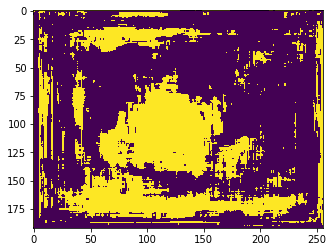

ground_truth segmentation 



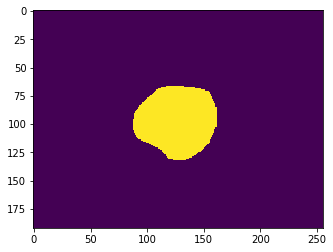

0.2148270973792443  step number is  0  batch_size is  16


In [0]:
steps = 10500
import time
batch_size = 16
j_test = []
j_train = []
pct = []

#use Cifar_helper to set up next batch
with tf.Session() as sess:
    print("starting init")
    sess.run(init)
    print("done init")
    
    start_time = time.clock()
    
    for i in range(steps): 
        batch_x, batch_y = mel.next_batch(batch_size)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5,hold_prob2:0.5})
        
        
        if i%100 == 0:
            print('Currently on step {}'.format(i))
            print("the time is ", time.clock() - start_time, "\n")
             
            
            pred_o = tf.math.round(pred)
            true_o = tf.math.round(true)

            #compute the jacc

            intersect_o = tf.reduce_sum(tf.cast(true*pred_o, tf.float32), axis = [1,2])
            union_o = tf.reduce_sum(tf.cast(pred_o, tf.float32), axis = [1,2]) + tf.reduce_sum(tf.cast(true, tf.float32), axis = [1,2]) - intersect_o  
            jacc_o = intersect_o/union_o
            pct_o = intersect_o/ tf.reduce_sum(tf.cast(pred_o, tf.float32), axis = [1,2])
            
            J_out_t = sess.run([jacc_o],feed_dict={x:batch_x,y_true:batch_y,hold_prob:1.0,hold_prob2:1.0})
            J_train = np.sum(J_out_t[0])/J_out_t[0].shape[0]
            j_train += [J_train]
            
            
            print('Avg Jacc is:')
            J_out = sess.run([jacc_o, pred_o, true_o, pct_o],feed_dict={x:mel.test_images,y_true:mel.test_labels,hold_prob:1.0, hold_prob2:1.0})
           
           
            rn = int(np.random.random()*J_out[1].shape[0])
            print("predicted segmentation \n")
            plt.imshow(J_out[1][rn, :, :])
            plt.show()
            print("ground_truth segmentation \n")
            plt.imshow(J_out[2][rn, :, :])
            plt.show()
            ##it cannot evaluate over the test set, the test set is too large...reduce size of test set (now 5%)
            
            J_test = np.sum(J_out[0])/J_out[0].shape[0]
            j_test += [J_test]
            pct += [J_out[3]]
            
            print(J_test, " step number is ",  i, " batch_size is ", batch_size)
          
           
        if i == steps - 1:
            pred_mel = sess.run([pred],feed_dict={x:mel.test_images,y_true:mel.test_labels,hold_prob:1.0, hold_prob2:1.0})
            pred_pigment = sess.run([pred],feed_dict={x:pigs,hold_prob:1.0,hold_prob2:1.0})
            
        save_path = saver.save(sess, "./model.ckpt")
        
        

Melanoma Segmentation Algorithm Performance

In [0]:
J_out[1].shape

Jaccard Index over Training Set

In [0]:
j_train = np.array(j_train)
j_test = np.array(j_test)
plt.plot(j_train)

Jaccard Index Over Test Set


In [0]:

plt.plot(j_test)

Jaccard distribution over the Test Set

In [0]:
plt.hist(J_out[0])

Jaccard Distribution over the Training Set

In [0]:
plt.hist(J_out_t[0])

Failure Rate on the Test Set

In [0]:
#failure rate on test set:
fails = 0
for a in J_out[0]:
  if a < 0.65:
    fails += 1
    
rate = fails/J_out[0].shape[0]
rate

## Analyze Pigmentation


In [0]:
plt.plot(pct)

In [0]:
plt.imshow(pred_pigment[0][5,:,:])
plt.show()

In [0]:
pigs.shape

In [0]:
pred_pigment[0].shape

In [0]:
plt.imshow(pigs[0]
plt.show()

In [0]:
def visual_progress():

  mask = np.zeros([192,256,3])#np.vstack([pred_pigment[0],pred_pigment[0],pred_pigment[0]])
  for i in range(28):
    mask[:,:,0] = np.around(pred_pigment[0][i])
    mask[:,:,1] = np.around(pred_pigment[0][i])
    mask[:,:,2] = np.around(pred_pigment[0][i])


    image = pigs[i]
    plt.imshow(image)
    plt.show()
    notmask = 1- mask
    image2 = image*mask
    image1 = image*(1- mask)

    image2_avgr = np.average(image2[:,:,0], weights = mask[:,:,0])
    image2_avgg = np.average(image2[:,:,1], weights = mask[:,:,1]) 
    image2_avgb = np.average(image2[:,:,2], weights = mask[:,:,2])

    image1_avgr = np.average(image1[:,:,0], weights = notmask[:,:,0])
    image1_avgg = np.average(image1[:,:,1], weights = notmask[:,:,1]) 
    image1_avgb = np.average(image1[:,:,2], weights = notmask[:,:,2])

    image2_avg = np.zeros(image2.shape)
    image1_avg = np.zeros(image1.shape)
    image2_avg[:,:,0] = image2_avgr
    image2_avg[:,:,1] = image2_avgg
    image2_avg[:,:,2] = image2_avgb

    image1_avg[:,:,0] = image1_avgr
    image1_avg[:,:,1] = image1_avgg
    image1_avg[:,:,2] = image1_avgb
#mask = 1-mask
#mask = mask.astype(int)
    plt.imshow(image2_avg)
    plt.show()
  
#image[mask] = 0

    plt.imshow(image1_avg)
    plt.show()

    plt.imshow(image2)
    plt.show()
    plt.imshow(image1)
    plt.show()

    print("next day..\n")
  return()

In [0]:
visual_progress()

In [0]:
def measure_progress(pigs,masks):  ##changed from blue to blue - red
    blue_pigs = []
    blue_norms = []
    imagesp = []
    imagesn = []
    i = 0
    for pig in pigs:
        mask = np.zeros([192,256,3])#np.vstack([pred_pigment[0],pred_pigment[0],pred_pigment[0]])
        mask[:,:,0] = pred_pigment[0][i,:,:]
        mask[:,:,1] = pred_pigment[0][i,:,:]
        mask[:,:,2] = pred_pigment[0][i,:,:]
        mask_inv = 1- mask
        imagep = pig*mask*255
        imagen = pig*(1- mask)*255
        imagesp += [imagep]
        imagesn += [imagen]
        blue_norm = imagen[:,:,2].reshape(-1) - imagen[:,:,0].reshape(-1) 
        blue_pig = imagep[:,:,2].reshape(-1) - imagep[:,:,0].reshape(-1)
        an = np.average(blue_norm, weights =mask_inv[:,:,0].reshape(-1))
        ap = np.average(blue_pig, weights =mask[:,:,0].reshape(-1))
        blue_pigs += [ap]
        blue_norms += [an]
        i+=1
    blue_pigs = np.array(blue_pigs)
    blue_norms = np.array(blue_norms)
    return(blue_pigs, blue_norms, imagesp, imagesn)

In [0]:
pigmented, normal, imagesp, imagesn = measure_progress(pigs,pred_pigment)

In [0]:
J_out[1].shape

In [0]:
plt.imshow(imagesn[0])

In [0]:
pigmented

In [0]:
normal

In [0]:
plt.plot(normal - pigmented)

In [0]:
plt.plot(normal)

In [0]:
plt.plot(pigmented)

In [0]:
plt.imshow(imagesp[0])

In [0]:
plt.imshow(imagesp[1])

In [0]:
plt.imshow(imagesp[2])

In [0]:
plt.imshow(imagesp[3])

In [0]:
plt.imshow(imagesp[4])

In [0]:
plt.imshow(imagesp[5])

In [0]:
plt.imshow(imagesp[6])

In [0]:
plt.imshow(imagesp[7])

In [0]:
plt.imshow(imagesp[8])

In [0]:
plt.imshow(imagesp[9])

In [0]:
plt.imshow(imagesp[10])

In [0]:
pigmented[0]

In [0]:
pigmented[10]

In [0]:
plt.imshow(imagesp[0])

In [0]:
plt.imshow(imagesp[11])

In [0]:
plt.imshow(imagesp[12])

In [0]:
plt.imshow(imagesp[13])

In [0]:
plt.imshow(imagesp[14])

In [0]:
plt.imshow(imagesp[15])

In [0]:
plt.imshow(imagesp[16])

In [0]:
plt.imshow(imagesp[17])

In [0]:
plt.imshow(imagesp[18])

In [0]:
plt.imshow(imagesp[19])

In [0]:
plt.imshow(imagesp[20])

In [0]:
plt.imshow(imagesp[21])

In [0]:
plt.imshow(imagesp[22])

In [0]:
plt.imshow(imagesp[23])

In [0]:
plt.imshow(imagesp[24])

In [0]:
plt.imshow(imagesp[25])

In [0]:
plt.imshow(imagesp[26])

In [0]:
plt.imshow(imagesp[27])

In [0]:
plt.imshow(imagesp[0])

In [0]:
test = normal - pigmented

In [0]:
test = np.hstack([test[0:2], test[4:8], test[9:21], test[22:26], test[27]])

In [0]:
plt.plot(test)

In [0]:
filenames

In [0]:
normal = np.hstack([normal[0:2], normal[12], normal[21:28], normal[2:12], normal[13:20]])

In [0]:
pigmented = np.hstack([pigmented[0:2], pigmented[12], pigmented[21:28], pigmented[2:12], pigmented[13:20]])

In [0]:
plt.plot(normal-pigmented)

In [0]:
## 26, 21, 2, 3, 8 -> 8,3,10,11,16

In [0]:
normal.shape

In [0]:
normal = np.hstack([normal[0:3], normal[4:8], normal[9], normal[12:16], normal[17:27]])

In [0]:
pigmented = np.hstack([pigmented[0:3], pigmented[4:8], pigmented[9], pigmented[12:16], pigmented[17:27]])

In [0]:
new_files_names = np.hstack([filenames[0:3], filenames[4:8], filenames[9], filenames[12:16], filenames[17:27]])

In [0]:
plt.plot(normal-pigmented)

In [0]:
plt.plot(pigmented)

In [0]:
plt.plot(normal)

In [0]:
plt.plot(pigmented/normal)

In [0]:
plt.plot((normal - pigmented)/normal)

In [0]:
new_files_names

In [0]:
plt.imshow(imagesp[12])